In [114]:
import numpy as np
from scipy.optimize import line_search

# About the conjugate gradient

# Conjugate gradient for linear optimization

- The conjugate gradient is an iterative method for solving a linear system of equations.
$$
Ax = b
$$


- $A$ is an *n x n* symmetric positive definit matrix.
The problem above can be stated equivalently as the following minimization problem:

$$
min\phi (x) = \frac{1}{2}x^T Ax - b^Tx
$$

- The gradient of $\phi$ is equal to the residual of the linear system:
$$\nabla \phi(x) = Ax - b = r(x)$$

This above is equivalent to minimizing a the function $\phi$

In [115]:
def conjugate_gradient(A, x0, b, eps=0.05):
    r = np.dot(A, x0) - b
    p = -r
    x = x0
    while np.linalg.norm(r) >= eps:
        r_prev = r
        Ap = np.dot(A, p)
        r_norm = np.linalg.norm(r)
        alpha = r_norm / np.dot(p, Ap)
        x = x + (alpha * p)
        r = r + alpha * Ap
        beta = np.linalg.norm(r) / np.linalg.norm(r_prev)
        p = -r + beta*p
    return  x

In [116]:
A = np.array([[2, -2, 0], [-1, 2, -1], [0, -1, 2]])
b = np.array([2, 3, 5])
x0 = np.array([0, 0, 0])

In [117]:
x_opt = conjugate_gradient(A, x0, b)

In [118]:
x_solve = np.linalg.solve(A, b)

In [119]:
np.testing.assert_allclose(x_opt, x_solve, rtol=1e-2)

In [120]:
x_opt

array([13.89398378, 12.8973112 ,  8.92860288])

The function above computes the conjugate gradient in the case of a linear equation. But in the case of machine learning cost functions are usually non linear. There is a specific approach to solving non linear equations with conjugate gradient.

# Nonlinear conjugate gradient (applied to machine learning)

The conjugate as shown previously can be viewed as a minimization algorithm for a convex quadratic function. But research sucessfully focused on generalizing the algorithm to non linear cases.
There are several methods available to compute the non linear conjugate gradient. Only the Fletcher-Reeves method will be introduced.

## Fletcher-Reeves method

There are two main changes in the cg algorithm with their approach. 
- The computation of $\alpha_k$. Computing $\alpha_k$  is made with a line search that identify an approximate minimum of the non linear fucntion along $p_k$.
- The residual $r$ which becomes the gradient of the non linear objective function to minimize $\nabla f$.

In [121]:
def rosenbrock_grad(x):
    y = np.asarray(x)
    grad = np.zeros_like(y)
    grad[0] = 400*y[0]*(y[0]**2-y[1]) + 2*(y[0]-1)
    grad[1] = 200*(y[1]-y[0]**2)
    return grad

In [122]:
def rosenbrock(x):
    y = np.asarray(x)
    return np.sum((y[0] - 1)**2 + 100*(y[1] - y[0]**2)**2)

In [179]:
from scipy.optimize import line_search
def conjugate_gradient(x0, obj_func, grd_func, args=(), epsilon=1.49e-08):
    
    f0 = obj_func(x0, *args)
    g0 = grd_func(x0, *args)
    p = -g0
    x = x0
    g = g0
    epoque = 0
    while np.linalg.norm(g) >= 0.000005:
        alpha, fc, gc, new_loss, old_loss, new_slope = line_search(f=obj_func, 
                                                                   myfprime=grd_func,
                                                                   xk=x,pk=p, gfk=g, old_fval=f0, args=args)
        x = x + alpha * p        
        h = grd_func(x, *args)
        dgg = np.linalg.norm(g)
        ngg = np.linalg.norm(h)
        
        # Fletcher-Reeves's beta (Eq 2.53)
#         beta = ngg / dgg
        
        # Ribière-Polak beta
        delta = np.dot(h, (h-g))
        beta = max(0, delta / dgg)
        
        x_old = x
        g = h
        p = -g + beta * p
        print(f"Epoque {epoque} and loss is: {new_loss}")
        epoque += 1
    return x

In [180]:
x0 = np.array([1.1,2.1])
conjugate_gradient(x0=25000, obj_func=lambda x: x**2, grd_func=lambda x: 2*x)

Epoque 0 and loss is: 0.0


0.0

In [181]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

def logistic_surrogate_loss(w, X, y):
    # Computing the dot product
    n, d = X.shape
    ps = np.dot(X, w[:-1]) + w[-1]
    yps = y * ps
#     loss = np.where(yps > 0,
#                    np.log(1 + np.exp(-yps)),
#                    (-yps + np.log(1 + np.exp(yps))))
#     loss = logistic(yps)
    loss = np.log(1. + np.exp(-yps))
#     loss = loss.sum()
#     loss /= n
    return np.mean(loss)

def gradient_log_surrogate_loss(w, X, y):
    # defining dim variables
    n, d = X.shape
    z = X.dot(w[:-1]) + w[-1]
    z = logistic(y*z)
    z0 = (z - 1) * y
    
    # initiating g: gradient vector
    g = np.zeros(d+1)
    # Computing dot product
    g[:-1] = X.T.dot(z0)
    g[-1] = z0.sum()
    g /= n
    return g

In [182]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=10, n_features=5)
w = np.random.random(X.shape[1]+1)

In [183]:
conjugate_gradient(x0=w, obj_func=logistic_surrogate_loss, grd_func=gradient_log_surrogate_loss, args=(X, y))

Epoque 0 and loss is: 0.7184473357312335
Epoque 1 and loss is: 0.5215088104207053
Epoque 2 and loss is: 0.46056255295073145
Epoque 3 and loss is: 0.43784268165807827
Epoque 4 and loss is: 0.4234654943135244
Epoque 5 and loss is: 0.4131800542499386
Epoque 6 and loss is: 0.40540589139615585
Epoque 7 and loss is: 0.3993129647452573
Epoque 8 and loss is: 0.3899647885596595
Epoque 9 and loss is: 0.383583564012226
Epoque 10 and loss is: 0.37892984486462805
Epoque 11 and loss is: 0.3753749991620277
Epoque 12 and loss is: 0.3725645528975735
Epoque 13 and loss is: 0.3682095611815009
Epoque 14 and loss is: 0.36519033463662237
Epoque 15 and loss is: 0.3629600937134409
Epoque 16 and loss is: 0.3612382088946793
Epoque 17 and loss is: 0.3586253068229937
Epoque 18 and loss is: 0.35685939270541767
Epoque 19 and loss is: 0.35557552577701923
Epoque 20 and loss is: 0.3545950344158659
Epoque 21 and loss is: 0.353819076354719
Epoque 22 and loss is: 0.35261429137823397
Epoque 23 and loss is: 0.3517759256419

array([ 0.78781141, -1.18665761, -2.58842429,  3.13096486, -1.88621361,
        8.43359203])

In [184]:
# Using scipy's conjugate gradient
from scipy.optimize import fmin_cg
fmin_cg(f=logistic_surrogate_loss, x0=w, fprime=gradient_log_surrogate_loss, args=(X, y))

Optimization terminated successfully.
         Current function value: 0.346580
         Iterations: 10
         Function evaluations: 46
         Gradient evaluations: 46


array([ 0.61341632, -1.23928536, -2.85981537,  3.15139145, -1.90408999,
        8.36007813])

In [185]:
x0 = np.array([1.1,2.1])
f0 = rosenbrock(x0)
g0 = rosenbrock_grad(x0)
p = -g0

In [186]:
# testing the rosenbrock function on line search
alpha, fc, gc, new_loss, old_loss, new_slope = line_search(f=rosenbrock, 
                                                           myfprime=rosenbrock_grad,
                                                           xk=x0,pk=p, gfk=g0, old_fval=f0)

In [187]:
alpha

0.0008127949077501714

In [188]:
# Using scipy's conjugate gradient
from scipy.optimize import fmin_cg
fmin_cg(f=rosenbrock, x0=x0, fprime=rosenbrock_grad)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 16
         Function evaluations: 37
         Gradient evaluations: 37


array([1.00000207, 1.00000412])

In [189]:
conjugate_gradient(x0=x0, obj_func=rosenbrock, grd_func=rosenbrock_grad)

Epoque 0 and loss is: 0.4857967970798106


/home/iaamini/Documents/ML_practice/ML_fundamentals/.ml_venv/lib/python3.7/site-packages/scipy/optimize/linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

Text(0, 0.5, 'y')

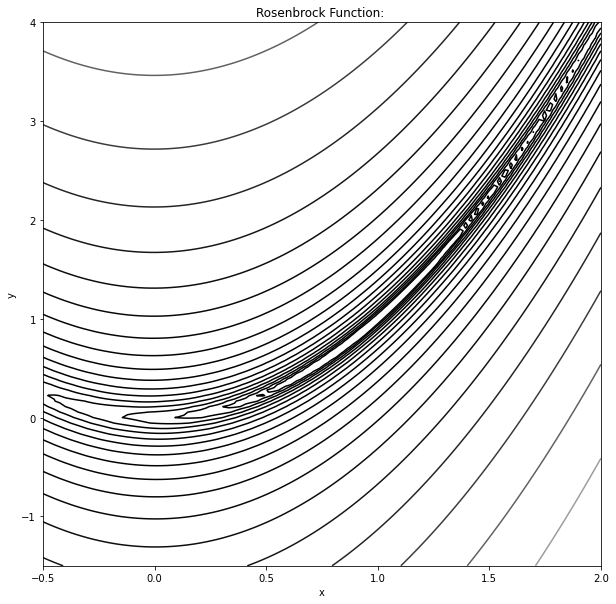

In [133]:
import matplotlib.pyplot as plt

X,Y = np.meshgrid(np.linspace(-.5,2.,100), np.linspace(-1.5,4.,100))
Z = rosenbrockfunction(X,Y)
plt.figure(figsize=(10, 10))
plt.contour(X,Y,Z,np.logspace(-0.5,3.5,20,base=10),cmap='gray')
plt.title('Rosenbrock Function: ')
plt.xlabel('x')
plt.ylabel('y')

In [155]:
ionosphere.describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,210.000000,210.000000,210.0,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,...,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,210.000000,0.0
mean,0.295238,0.900000,0.0,0.631368,0.061932,0.602395,0.140434,0.569946,0.117854,0.526268,...,-0.056948,0.542220,-0.061561,0.393766,-0.035029,0.361959,0.021175,0.368521,0.012939,NaN
std,0.957707,0.300717,0.0,0.499518,0.457744,0.529439,0.475132,0.465621,0.506665,0.480102,...,0.511918,0.510968,0.543178,0.568881,0.498256,0.569647,0.493755,0.522521,0.443282,NaN
min,-1.000000,0.000000,0.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,NaN
25%,-1.000000,1.000000,0.0,0.451672,-0.060828,0.432487,-0.022968,0.282760,-0.049593,0.078192,...,-0.290500,0.295075,-0.318875,0.000000,-0.243330,0.000000,-0.198625,0.000000,-0.121055,NaN
50%,1.000000,1.000000,0.0,0.867890,0.025385,0.827460,0.042080,0.741245,0.011100,0.702940,...,-0.007665,0.694540,-0.016600,0.526815,0.000000,0.468470,0.000000,0.424970,0.000000,NaN
75%,1.000000,1.000000,0.0,1.000000,0.194727,1.000000,0.361655,0.957828,0.378933,0.934673,...,0.178375,0.999972,0.168117,0.903060,0.151715,0.872840,0.211685,0.852897,0.186600,NaN
max,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN


In [162]:
import pandas as pd
ionosphere = pd.read_csv('/home/iaamini/Documents/ML_practice/LogisticRegression/example/IONO-Train', sep=' ', header=None)
X = ionosphere.iloc[:, 0:-2]
y = ionosphere.iloc[:, 0]
w = np.random.random(X.shape[1]+1)

In [169]:
fmin_cg(f=logistic_surrogate_loss, x0=w, fprime=gradient_log_surrogate_loss, args=(X, y))

Optimization terminated successfully.
         Current function value: 0.000005
         Iterations: 11
         Function evaluations: 60
         Gradient evaluations: 60


array([11.45303715,  0.19122556,  0.62202889,  1.0414688 , -0.01704207,
        0.75293889,  0.48979801,  0.5135488 ,  0.57145629,  0.4976134 ,
        0.57526913,  0.10831067, -0.23566297, -0.07474454,  0.80596785,
        0.15094255, -0.07000518, -0.22448421,  0.06938734, -0.12763992,
       -0.27149949,  0.0630364 , -0.92327157,  0.27738967,  0.27558706,
        0.03518213,  0.24699068, -1.00373986, -0.10363924,  0.56641996,
        0.30078268,  0.40106515, -0.62214897, -0.13656568, -1.05246291])

In [173]:
conjugate_gradient(x0=w, obj_func=logistic_surrogate_loss, grd_func=gradient_log_surrogate_loss, args=(X, y))

Epoque 0 and loss is: 0.7029357786604737
Epoque 1 and loss is: 0.4642191952414362
Epoque 2 and loss is: 0.29848204850973686
Epoque 3 and loss is: 0.20324069269315873
Epoque 4 and loss is: 0.15579491582292126
Epoque 5 and loss is: 0.1302891169692928
Epoque 6 and loss is: 0.11340555793091418
Epoque 7 and loss is: 0.10051083753986324
Epoque 8 and loss is: 0.08063697049696124
Epoque 9 and loss is: 0.06698766583288611
Epoque 10 and loss is: 0.057174529951567805
Epoque 11 and loss is: 0.04985707730008632
Epoque 12 and loss is: 0.04422214281997476
Epoque 13 and loss is: 0.0397614932028625
Epoque 14 and loss is: 0.03287024707954649
Epoque 15 and loss is: 0.028131631209763343
Epoque 16 and loss is: 0.024658450546495805
Epoque 17 and loss is: 0.021993762792988456
Epoque 18 and loss is: 0.01797462934257096
Epoque 19 and loss is: 0.015278576405271036
Epoque 20 and loss is: 0.01332681581017657
Epoque 21 and loss is: 0.01184033403114134
Epoque 22 and loss is: 0.010666262578274213
Epoque 23 and loss 

Epoque 181 and loss is: 6.8487458560991525e-06
Epoque 182 and loss is: 6.799619143062422e-06
Epoque 183 and loss is: 6.751194283947212e-06
Epoque 184 and loss is: 6.70345632021375e-06
Epoque 185 and loss is: 6.656390715790684e-06
Epoque 186 and loss is: 6.609983342420757e-06
Epoque 187 and loss is: 6.564220465340568e-06
Epoque 188 and loss is: 6.519088729652896e-06
Epoque 189 and loss is: 6.474575147378833e-06
Epoque 190 and loss is: 6.430667084820804e-06
Epoque 191 and loss is: 6.387352250611758e-06
Epoque 192 and loss is: 6.34461868416084e-06
Epoque 193 and loss is: 6.3024547446245694e-06
Epoque 194 and loss is: 6.260849100271314e-06
Epoque 195 and loss is: 6.2197907182697585e-06
Epoque 196 and loss is: 6.179268854847421e-06
Epoque 197 and loss is: 6.1392730460116625e-06
Epoque 198 and loss is: 6.099793098353168e-06
Epoque 199 and loss is: 6.060819080417196e-06
Epoque 200 and loss is: 6.0223413143148435e-06
Epoque 201 and loss is: 5.984350367706469e-06
Epoque 202 and loss is: 5.94683

array([11.44187889,  0.15999917,  0.62202889,  0.94259088, -0.01596166,
        0.69911718,  0.47018654,  0.45809676,  0.535931  ,  0.45298793,
        0.53711978,  0.04478075, -0.20853985, -0.10205656,  0.76549653,
        0.09928872, -0.06567026, -0.24841468,  0.05418559, -0.16418159,
       -0.23696868,  0.02923192, -0.86699109,  0.21782201,  0.26683578,
        0.03393911,  0.23900989, -0.96932065, -0.09117834,  0.54413291,
        0.32335381,  0.38985389, -0.56393622, -0.1131676 , -1.03486863])

In [272]:
import pandas as pd
from sklearn.model_selection import train_test_split

breast_cancer = pd.read_csv('../../DB/breast-cancer-wisconsin.data', sep=',', header=None)
breast_cancer.columns = ['col' + str(i) for i in range(len(breast_cancer.columns))]
breast_cancer.drop('col6', inplace=True, axis=1)
X = breast_cancer.iloc[:, 1:-1]
y = breast_cancer.iloc[:, -1]
y[y==2] = -1
y[y==4] = 1

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, 
                                                    test_size=.4, shuffle=True)